**Samuel Munoz**

Spring 2021

CS 251: Data Analysis and Visualization

Project 6: Supervised learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 3: Preprocess full spam email dataset 

Before you build a Naive Bayes spam email classifier, run the full spam email dataset through your preprocessing code.

Download and extract the full **Enron** emails (*zip file should be ~29MB large*). You should see a base `enron` folder, with `spam` and `ham` subfolders when you extract the zip file (these are the 2 classes).

Run the test code below to check everything over.

### 3a) Preprocess dataset

In [2]:
import email_preprocessor as epp

#### Test `count_words` and `find_top_words`

In [44]:
word_freq, num_emails = epp.count_words()

In [4]:
print(f'You found {num_emails} emails in the datset. You should have found 32625.')

You found 32625 emails in the datset. You should have found 32625.


In [45]:
top_words, top_counts = epp.find_top_words(word_freq)
print(f"Your top 5 words are\n{top_words[:5]}\nand they should be\n['the', 'to', 'and', 'of', 'a']")
print(f"The associated counts are\n{top_counts[:5]}\nand they should be\n[277459, 203659, 148873, 139578, 111796]")

Your top 5 words are
['the', 'to', 'and', 'of', 'a']
and they should be
['the', 'to', 'and', 'of', 'a']
The associated counts are
[277459, 203659, 148873, 139578, 111796]
and they should be
[277459, 203659, 148873, 139578, 111796]


### 3b) Make train and test splits of the dataset

Here we divide the email features into a 80/20 train/test split (80% of data used to train the supervised learning model, 20% we withhold and use for testing / prediction).

In [46]:
features, y = epp.make_feature_vectors(top_words, num_emails)

In [47]:
np.random.seed(0)
x_train, y_train, inds_train, x_test, y_test, inds_test = epp.make_train_test_sets(features, y)

In [8]:
print('Shapes for train/test splits:')
print(f'Train {x_train.shape}, classes {y_train.shape}')
print(f'Test {x_test.shape}, classes {y_test.shape}')
print('\nThey should be:\nTrain (26100, 200), classes (26100,)\nTest (6525, 200), classes (6525,)')

Shapes for train/test splits:
Train (26100, 200), classes (26100,)
Test (6525, 200), classes (6525,)

They should be:
Train (26100, 200), classes (26100,)
Test (6525, 200), classes (6525,)


### 3c) Save data in binary format

It adds a lot of overhead to have to run through your raw email -> train/test feature split every time you wanted to work on your project! In this step, you will export the data in memory to disk in a binary format. That way, you can quickly load all the data back into memory (directly in ndarray format) whenever you want to work with it again. No need to parse from text files!

- Use numpy's `save` function to make six files in `.npy` format (e.g. `email_train_x.npy`, `email_train_y.npy`, `email_train_inds.npy`, `email_test_x.npy`, `email_test_y.npy`, `email_test_inds.npy`).

In [48]:
# store all trainiing and testing data sets into files
# root directory of file
root_filepath = "data/subdata"
np.save(root_filepath + "/email_train_x.npy", x_train)
np.save(root_filepath + "/email_train_y.npy", y_train)
np.save(root_filepath + "/email_train_inds.npy", inds_train)
np.save(root_filepath + "/email_test_x.npy", x_test)
np.save(root_filepath + "/email_test_y.npy", y_test)
np.save(root_filepath + "/email_test_inds.npy", inds_test)

## Task 4: Naive Bayes Classifier

After finishing your email preprocessing pipeline, implement the one other supervised learning algorithm we we will use to classify email, **Naive Bayes**.

### 4a) Implement Naive Bayes

In `naive_bayes.py`, implement the following methods:
- Constructor
- `train(data, y)`: Train the Naive Bayes classifier so that it records the "statistics" of the training set: class priors (i.e. how likely an email is in the training set to be spam or ham?) and the class likelihoods (the probability of a word appearing in each class — spam or ham).
- `predict(data)`: Combine the class likelihoods and priors to compute the posterior distribution. The predicted class for a test sample is the class that yields the highest posterior probability.
- `accuracy(y, y_pred)`: The usual definition :)


#### Bayes rule ingredients: Priors and likelihood (`train`)

To compute class predictions (probability that a test example belong to either spam or ham classes), we need to evaluate **Bayes Rule**. This means computing the priors and likelihoods based on the training data.

**Prior:** $$P_c = \frac{N_c}{N}$$ where $P_c$ is the prior for class $c$ (spam or ham), $N_c$ is the number of training samples that belong to class $c$ and $N$ is the total number of training samples.

**Likelihood:** $$L_{c,w} = \frac{N_{c,w} + 1}{N_{c} + M}$$ where
- $L_{c,w}$ is the likelihood that word $w$ belongs to class $c$ (*i.e. what we are solving for*)
- $N_{c,w}$ is the total count of **word $w$** in emails that are only in class $c$ (*either spam or ham*)
- $N_{c}$ is the total number of **all words** that appear in emails of the class $c$ (*total number of words in all spam emails or total number of words in all ham emails*)
- $M$ is the number of features (*number of top words*).

#### Bayes rule ingredients: Posterior (`predict`)

To make predictions, we now combine the prior and likelihood to get the posterior:

**Log Posterior:** $$Log(\text{Post}_{i, c}) = Log(P_c) + \sum_{j \in J_i}x_{i,j}Log(L_{c,j})$$

 where
- $\text{Post}_{i,c}$ is the posterior for class $c$ for test sample $i$(*i.e. evidence that email $i$ is spam or ham*). We solve for its logarithm.
- $Log(P_c)$ is the logarithm of the prior for class $c$.
- $x_{i,j}$ is the number of times the jth word appears in the ith email.
- $Log(L_{c,j})$: is the log-likelihood of the jth word in class $c$.

In [10]:
from naive_bayes_multinomial import NaiveBayes

#### Test `train`

In [11]:
num_test_classes = 4
np.random.seed(0)
data_test = np.random.random(size=(100, 6))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_test, y_test)

print(f'Your class priors are: {nbc.class_priors}\nand should be          [0.24 0.26 0.25 0.25].')
print(f'Your class likelihoods shape is {nbc.class_likelihoods.shape} and should be (4, 6).')
print(f'Your likelihoods are:\n{nbc.class_likelihoods}')


test_likelihoods = np.array([[0.15116, 0.18497, 0.17571, 0.1463 , 0.16813, 0.17374],
       [0.16695, 0.17437, 0.15742, 0.16887, 0.15677, 0.17562],
       [0.14116, 0.1562 , 0.19651, 0.17046, 0.17951, 0.15617],
       [0.18677, 0.18231, 0.15884, 0.12265, 0.16755, 0.18187]])
print(f'and should be\n{test_likelihoods}')

Your class priors are: [0.24 0.26 0.25 0.25]
and should be          [0.24 0.26 0.25 0.25].
Your class likelihoods shape is (4, 6) and should be (4, 6).
Your likelihoods are:
[[0.15116 0.18497 0.17571 0.1463  0.16813 0.17374]
 [0.16695 0.17437 0.15742 0.16887 0.15677 0.17562]
 [0.14116 0.1562  0.19651 0.17046 0.17951 0.15617]
 [0.18677 0.18231 0.15884 0.12265 0.16755 0.18187]]
and should be
[[0.15116 0.18497 0.17571 0.1463  0.16813 0.17374]
 [0.16695 0.17437 0.15742 0.16887 0.15677 0.17562]
 [0.14116 0.1562  0.19651 0.17046 0.17951 0.15617]
 [0.18677 0.18231 0.15884 0.12265 0.16755 0.18187]]


#### Test `predict`

In [12]:
num_test_classes = 4
np.random.seed(0)
data_train = np.random.randint(low=0, high=num_test_classes, size=(100, 10))
data_test = np.random.randint(low=0, high=num_test_classes, size=(15, 10))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_train, y_test)
test_y_pred = nbc.predict(data_test)

print(f'Your predicted classes are\n{test_y_pred}\nand should be\n[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]')

Your predicted classes are
[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]
and should be
[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]


### 4b) Spam filtering

Let's start classifying spam email using the Naive Bayes classifier.

- Use `np.load` to load in the train/test split that you created last week.
- Use your Naive Bayes classifier on the Enron email dataset!

**Question 7:** Print out the accuracy that you get on the test set with Naive Bayes. It should be roughly 89%.

In [13]:
import email_preprocessor as ep

In [49]:
# load in train and test split created
x_train = np.load("data/subdata/email_train_x.npy")
y_train = np.load("data/subdata/email_train_y.npy")
inds_train = np.load("data/subdata/email_train_inds.npy")
x_test = np.load("data/subdata/email_test_x.npy")
y_test = np.load("data/subdata/email_test_y.npy")
inds_test = np.load("data/subdata/email_test_inds.npy")

In [39]:
# train and predict
classifier = NaiveBayes(2)
classifier.train(x_train, y_train)
pred = classifier.predict(x_test)

# check accuracy
print(f"Accuracy: {classifier.accuracy(y_test, pred)}")

Accuracy: 0.8993103448275862


### 4c) Confusion matrix

To get a better sense of the errors that the Naive Bayes classifer makes, you will create a confusion matrix. 

- Implement `confusion_matrix` in `naive_bayes.py`.
- Print out a confusion matrix of the spam classification results.

**Debugging guidelines**:
1. The sum of all numbers in your 2x2 confusion matrix should equal the number of test samples (6525).
2. The sum of your spam row should equal the number of spam samples in the test set (3193)
3. The sum of your ham row should equal the number of spam samples in the test set (3332)

In [57]:
import time
t0 = time.time()

#### ADDED IN FOR FAIR COMPARSION LATTER IN NOTEBOOK
# train and predict
classifier = NaiveBayes(2)
classifier.train(x_train, y_train)
pred = classifier.predict(x_test)

# check accuracy
print(f"Accuracy: {classifier.accuracy(y_test, pred)}")
#####################################################


# print confusion matrix
conf_matrix = classifier.confusion_matrix(y_test, pred)
print(conf_matrix)

print(f"\n# of Ham Emails: {y_test[y_test == 0].size}")
print(f"# of Spam Emails: {y_test[y_test == 1].size}\n")

print(f"Row sums: {np.sum(conf_matrix, axis=1)}")
print(f"Total sum: {np.sum(conf_matrix)}")

t1 = time.time()
print(f"Time taken: {t1 -t0}")

Accuracy: 0.8993103448275862
[[3072.  172.]
 [ 485. 2796.]]

# of Ham Emails: 3244
# of Spam Emails: 3281

Row sums: [3244. 3281.]
Total sum: 6525.0
Time taken: 5.527576923370361


**Question 8:** Interpret the confusion matrix, using the convention that positive detection means spam (*e.g. a false positive means classifying a ham email as spam*). What types of errors are made more frequently by the classifier? What does this mean (*i.e. X (spam/ham) is more likely to be classified than Y (spam/ham) than the other way around*)?

**Reminder:** Look back and make sure you are clear on which class indices correspond to spam/ham.

**Answer 8:** In the confusion matrix above, the first row represent the actual negative detections and the second row represents the acutal positive detections. The first column represents the emails predicted negative detection and the second column represents the predicted positive detection. The entry in the top left corner shows the number of negative detections that were predicted as negative detections (ham emails predicted as ham). The entry in the top right corner shows the number of negative detections that were incorrectly predicted as positive detections (ham emails predicted as spam emails). These are the number of false positives in my model. The entry in the bottom left corner are the positive detections predicted to be negative detections (number of spam emails predicted as ham emails). These are the number of false negatives in my model. Lastly, the entry in the bottom right corner are all positive detections predicted as positive detections (number of spam email predicted to be spam emails).

It was more common to have false negatives than false positive because the number in the bottom right corner is greater than the number in the top right corner. This would imply that if someone used this algorithm to filter out ham and spam emails, there would be more spam emails making into this person's inbox than the number of real emails being marked as spam.

### 4d) Investigate the misclassification errors

Numbers are nice, but they may not the best for developing your intuition. Sometimes, you want to see what an misclassification *actually looks like* to help you improve your algorithm. Here, you will take a false positive and a false negative misclassification and retrieve the actual text of the email so see which emails produced the error.

- Determine the index of the **FIRST** false positive and false negative misclassification — i.e. 2 indices in total. Remember to use your `test_inds` array to look up the index of the emails BEFORE shuffling happened.
- Implement the function `retrieve_emails` in `email_preprocessor.py` to return the string of the raw email at the error indices.
- Call your function to print out the two emails that produced misclassifications.

**Question 9:** Does it seem reasonable that each email message was misclassified? Why?

**Answer 9:** I think the emails were reasonable misclassified. For the false positive, this appears to be reminder to some one that there was some meeting. This information is stored in the subject line, which isn't going to be too long in comparsion with the rest of the email. The rest email contains contact information. I believe that this contact information caused the error because I would expect spam email to be littered with spam email and that would make this email have more similarities to spam emails.

The false negative makes sense since this is an email about some amazon order. At first glance, this is a long email refunding the client their money. I thought this email was not spam myself until I check the actual class of the email. The class is spam. Therefore, I assume that maybe emails from amazon.com were not suppose to sent to the user's email or this email could be potentially be bogus amazon.com email. Regardless, if I having issues seeing that this email is false, then it makes sense for the algorithm to make that mistake.

In [56]:
# compare classes
compare = y_test - pred

# if false positive: then y_test[i] = 0 and pred = 1. Therefore, compare[i] = -1; 
# these are the minimum value of the list
fp = np.where(compare == -1)[0]

# if false negative: then y_test[i] = 1 and pred = 0. Therefore, compare[i] = 1; 
# these are the maximum value of the list
fn = np.where(compare == 1)[0]

# pull first index in list and place them into an ndarray to run retrieve emails function
inds = np.array([fp[0], fn[0]])

emails = ep.retrieve_emails(inds)

# verify correctness of algorithm
print(f"False positive: y_test: {y_test[inds[0]]}; pred: {pred[inds[0]]}")
print(f"False negative: y_test: {y_test[inds[1]]}; pred: {pred[inds[1]]}")

# print emails
print("\nFalse Positive:\n", emails[0])
print("\nFalse Negative:\n", emails[1])

False positive: y_test: 0.0; pred: 1
False negative: y_test: 1.0; pred: 0

False Positive:
 Subject: enron corp . board of directors meeting - october 9 , 2001
kelly m . johnson
executive assistant
enron corp .
tel : 713 - 853 - 6485
fax : 713 - 853 - 2534
e - mail : kelly . johnson @ enron . com

False Negative:
 Subject: your amazon . com order ( # 104 - 9670681 - 0325567 )
hello from amazon . com .
we ' re writing to confirm that we have processed your refund for
$ 18 . 00 for the above - referenced order .
this amount should appear as a credit on your next credit card statement .
for more information about this refund , please visit your account
( http : / / www . amazon . com / your - account ) to view the above - referenced order .
completed returns and refunds will appear at the bottom of the order
summary page .
we hope that this is a satisfactory resolution for you .
if you have any questions , please contact us via e - mail , fax , or
phone :
e - mail : orders @ amazon . com


## Task 5: Comparison with KNN


- Run a similar analysis to what you did with Naive Bayes above. When computing accuracy on the test set, you may want to reduce the size of the test set (e.g. to the first 500 emails in the test set).
- Copy-paste your `confusion_matrix` method into `knn.py` so that you can run the same analysis on a KNN classifier.

In [18]:
from knn import KNN

In [19]:
import time
t0 = time.time()

# train data
classifier = KNN(2)
classifier.train(x_train, y_train)

# get predictions
pred = classifier.predict(x_test, 5)

# compute and print accuracy with first 500 samples
print(f"Accuracy: {classifier.accuracy(y_test[:500], pred[:500])}")

# compute confusion matrix on first 500 samples
c_matrix = classifier.confusion_matrix(y_test, pred) 
print(c_matrix)

t1 = time.time()
print(f"Time taken: {t1 -t0}")

Accuracy: 0.92
[[3083.  161.]
 [ 371. 2910.]]
Time taken: 372.0993673801422


**Question 10:** What accuracy did you get on the test set (potentially reduced in size)?

**Question 11:** How does the confusion matrix compare to that obtained by Naive Bayes (*If you reduced the test set size, keep that in mind*)?

**Question 12:** Briefly describe at least one pro/con of KNN compared to Naive Bayes on this dataset.

**Question 13:** When potentially reducing the size of the test set here, why is it important that we shuffled our train and test set?

**Answer 10:** I got a 92% accuracy.

**Answer 11:** Overall, the confusion matrix shows that this algorithm makes less false positives and false negatives. First, the sum of entries matrix is the same has the sum of all entries in the previous matrix. This confusion matrix made only 161 false positives where the confusion matrix for the Naive Baye algorithm made 172. This algorithm is better. Additionally, the confusion matrix for the KNN algorithm shows that this model only made 371 false negatives. This is better than than the 485 false negatives in the Naive Bayes algorithm.

**Answer 12:** One pro to the KNN algorithm is that it is more accurate than the Naive Bayes algorithm (look at confusion matrix). However, one con of the KNN algorithm is that it takes much longer for the KNN algorithm to run than the Naive Bayes algorithm to the run. KNN took 6 minutes to run! Naive Bayes ran in 5 seconds. It is huge improvement. This shows that Naive Bayes could easily handle larger datasets where as KNN would struggle to run in a short peroid of time.

**Answer 13:** This is to ensure that the samples used where randomized. If they weren't, it could be that the samples in an unrandomized subset of all emails could have a higher variance or some anomaly that would yield a prediction that is not representative of the rest of the data.

## Extensions

### 0. Classify your own datasets

- Find datasets that you find interesting and run classification on them using your KNN algorithm (and if applicable, Naive Bayes). Analysis the performance of your classifer.

### 1. Better text preprocessing

- If you look at the top words extracted from the email dataset, many of them are common "stop words" (e.g. a, the, to, etc.) that do not carry much meaning when it comes to differentiating between spam vs. non-spam email. Improve your preprocessing pipeline by building your top words without stop words. Analyze performance differences.

### 2. Feature size

- Explore how the number of selected features for the email dataset influences accuracy and runtime performance.

### 3. Distance metrics
- Compare KNN performance with the $L^2$ and $L^1$ distance metrics

### 4. K-Fold Cross-Validation

- Research this technique and apply it to data and your KNN and/or Naive Bayes classifiers.

**K-Fold Cross-Validation Extension**

For this extension, I looked up the algorithm for the K-Fold Cross-Validation. The idea of the algorithm is that given a data set with its samples, I split the data set into k groups with roughly an equal number of samples per group. Then, iterating through each group, the i-th group would become a test data set and the remaining data sets would become the training data set. I would train the model (KNN or Naive Bayes in this case) and measure the performance of the model. Traditionally, MSE is used here. However, I have modified the algorithm to use the `accuracy` function to measure the quality of the model. I thought this information would be more meaningful than computing MSE. I know what accuracy means, but MSE does not provide any meaningful information about the ham/spam emails. Repeat this process for all groups and the result will be a `(M,)` array with accuracy of the model for all groups. Take the average of all accuracy values and that is what is returned by my K-Fold Cross-Validation method (KFCV).

The purpose of this algorithm is to check the performance of a model. The interpretation of the results of this algorithm vary based on the metric used to mesure the performance of the model. In this case, accuracy measure performance. The higher the accuracy, the better.

I created the algorithm for both KNN and Naive Bayes. Given that KNN takes forever to run on my computer, I tested KNN over a small number of emails. However, it appears that the algorithm does not work correctly on a subset of the data. The same occurs with the Naive Bayes algorithm. I have omitted testing code for the KNN KFCF algorithm for these reasons. However,using the full data set does not yield this error. I was interested in seeing relationship between average accuracy of the data set and the number of $k$. I expected that the average accuracy would increase with $k$ because when $k$ increases, the algorithm will create a larger training data set (more groups means that the size of each group decreases). Therefore, a larger training data set would be more accurate.

However, the plot below shows that this is not case. It appears that it doesn't matter the value of $k$, the average accuracy remains constant for the values of $k$ I tested. I suppose that any variances of one groups gets "washed out" by the average accuracies of the other groups. This leads to more constant results.

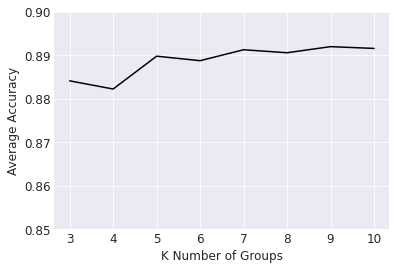

In [79]:
# change font size
plt.rcParams['font.size'] = '12'

# testing k-fold cross validation
classifier = NaiveBayes(2)
validation = []
for i in range(3, 11):
    validation.append(classifier.k_fold_cross_validation(features, y, i))
    
k_values = np.arange(3, 11)
validation = np.array(validation)
plt.plot(k_values, validation, "k-")
plt.xticks(k_values)
plt.xlabel("K Number of Groups")
plt.ylabel("Average Accuracy")
plt.yticks(np.arange(0.85, 0.9, 0.01))
plt.show()

In [83]:
# testing k-fold cross validation
kclassifier = KNN(2)
k_validation = []
for i in range(3, 5):
    k_validation.append(kclassifier.k_fold_cross_validation(features, y, 7, i))
    
kk_values = np.arange(3, 5)
plt.plot(kk_values, k_validation, "k-")
plt.show()

### 5. Email error analysis

- Dive deeper into the properties of the emails that were misclassified (FP and/or FN) by Naive Bayes or KNN. What is their word composition? How many words were skipped because they were not in the training set? What could plausibly account for the misclassifications?